In [1]:
import utils
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


from torch.nn.utils.rnn import pad_packed_sequence
from torch.utils.data import DataLoader

In [2]:
# --- Input Directories ---
# Data Input: Livings data from S1.2
DATA_INPUT_DIR = utils.RESULTS_DIR / "S1" / "S1.2"
# Model Input: Trained models from S4.1
MODEL_INPUT_DIR = utils.RESULTS_DIR / "S4" / "S4.1"

# --- Output Directory ---
# Target: results/S4/S4.2
OUTPUT_DIR = utils.RESULTS_DIR / "S4" / "S4.2"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

data_file_path = DATA_INPUT_DIR / "livings.csv"

if not data_file_path.exists():
    raise FileNotFoundError(f"Data file not found: {data_file_path}\nPlease run S1.2 first.")

total_data = pd.read_csv(data_file_path)
print(f"Loaded data: {data_file_path.name} | Shape: {total_data.shape}")
total_data.head()

Loaded data: livings.csv | Shape: (10393, 65)


,projid,fu_year,study,cogdx,age_at_visit,bmi,cogn_global,cts_mmse30,dbp_avg,sbp_avg,...,rigidsc,tremsc,q1slp,q2slp,q4slp,q5slp,gpath,tangles,amyloid,niareagansc
0,617643,0,MAP,NaN,0.130205,0.525144,0.851580,0.966667,0.446809,0.453333,...,0.0,0.0,0.250,0.375,0.500,0.000,NaN,NaN,NaN,NaN
1,617643,1,MAP,NaN,0.149299,0.551277,0.837993,1.000000,0.542553,0.513333,...,0.0,0.0,0.375,0.375,0.500,0.000,NaN,NaN,NaN,NaN
2,617643,2,MAP,NaN,0.169506,0.552938,0.862900,1.000000,0.510638,0.580000,...,0.0,0.0,0.250,0.125,0.375,0.125,NaN,NaN,NaN,NaN
3,617643,3,MAP,NaN,0.190158,0.548967,0.880757,1.000000,0.515957,0.676667,...,0.0,0.0,0.250,0.250,0.500,0.125,NaN,NaN,NaN,NaN
4,617643,4,MAP,NaN,0.209753,0.564849,0.864275,1.000000,0.351064,0.456667,...,0.0,0.0,0.250,0.500,0.500,0.125,NaN,NaN,NaN,NaN


In [3]:
# Checking data
na_counts = total_data.isna().sum()
na_columns = na_counts[na_counts > 0]
print(na_columns) # It seems I need to remove all the rows with any NA in it except for the 4 pathologies rows.

cogdx          9718
gpath          9782
tangles        9823
amyloid        9809
niareagansc    9782
dtype: int64


In [4]:
# In the previous version, there is no NA. Then I thought maybe the NAs are the problem.
# The below code is used to remove all the rows including NA except the NA in the 5 columns.

cols_to_ignore = ['gpath', 'tangles', 'amyloid', 'niareagansc', 'cogdx']

cols_to_check = [col for col in total_data.columns if col not in cols_to_ignore]

total_data_clean = total_data.dropna(subset=cols_to_check)

print(total_data_clean.shape)


(10393, 65)


In [5]:
# Checking data
na_counts_clean = total_data_clean.isna().sum()
na_columns_clean = na_counts_clean[na_counts_clean > 0]
print(na_columns_clean) # It seems I need to remove all the rows with any NA in it except for the 4 pathologies rows.

cogdx          9718
gpath          9782
tangles        9823
amyloid        9809
niareagansc    9782
dtype: int64


In [6]:
# Change the name of 'total_data_clean' back to 'total_data' for the easier following steps.
total_data = total_data_clean

In [7]:
class Model_AllTimeSteps_BiLSTMasTrue(nn.Module): # Original Name as LSTMModelAllTimeSteps
    """
    BiLSTM model to predict outcomes at ALL time steps.
    Same architecture/weights as your original last-step model,
    without the extra ReLU layer.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout=0.5, bidirectional=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            dropout=(dropout if num_layers > 1 else 0.0),
            batch_first=True,
            bidirectional=bidirectional
        )

        # BatchNorm and FC must match hidden_dim * num_directions
        self.batch_norm = nn.BatchNorm1d(hidden_dim * self.num_directions)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

    def forward(self, x):
        # x: PackedSequence
        packed_out, _ = self.lstm(x)
        padded_out, lengths = pad_packed_sequence(packed_out, batch_first=True)
        # padded_out shape: (batch, seq_len, hidden_dim * num_directions)

        # BatchNorm over feature dim: reshape to (batch, features, seq_len)
        normed = self.batch_norm(padded_out.transpose(1, 2))
        normed = normed.transpose(1, 2)  # back to (batch, seq_len, hidden_dim * num_directions)

        # Linear projection at each time step
        preds = self.fc(normed)  # (batch, seq_len, output_dim)
        return preds


In [8]:
class Model_AllTimeSteps_BiLSTMasTrue_ReLU(nn.Module): # Original Name as LSTMModelAllTimeSteps_BiLSTMasTrue_ReLU
    """
    Modified LSTM model to predict outcomes at ALL time steps.
    Uses the same architecture/weights as your original last-step model.
    """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5, bidirectional=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers,
            dropout=dropout if num_layers > 1 else 0.0,
            batch_first=True,
            bidirectional=bidirectional
        )
        
        # Adjust BatchNorm and FC input dimensions based on bidirectionality
        self.batch_norm = nn.BatchNorm1d(hidden_dim * self.num_directions)
        self.relu = nn.ReLU()  
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)


    def forward(self, x):
        # x is the input in PackedSequence format

        # 1. Pass through LSTM to get the outputs for all time steps (in packed format)
        packed_output, _ = self.lstm(x)
        
        # 2. Convert packed_output to a padded tensor and also obtain the actual length of each sequence
        padded_output, lengths = pad_packed_sequence(packed_output, batch_first=True)
        # padded_output 的形状: (batch_size, max_seq_length, hidden_dim * num_directions)
        
        # 3. Apply BatchNorm1d: first reshape the tensor to (batch_size, features, seq_length)
        norm_output = self.batch_norm(padded_output.transpose(1, 2))
        norm_output = norm_output.transpose(1, 2)  # 转回 (batch_size, seq_length, hidden_dim * num_directions)
        
        # 4. Apply ReLU activation function
        relu_output = self.relu(norm_output)
        
        # 5. Apply the fully connected layer to all time steps to obtain the final predictions
        predictions = self.fc(relu_output)  # 输出形状: (batch_size, seq_length, output_dim)
        
        return predictions


In [9]:
# Create sequences while preserving projid information
def create_sequences_with_ids(df, ids, feature_cols, target_cols):
    sequences = []
    for projid in ids:
        patient_df = df[df['projid'] == projid].sort_values('fu_year')
        features = patient_df[feature_cols].values.astype('float32')
        targets = patient_df[target_cols].values.astype('float32')
        sequences.append((projid, features, targets))
    return sequences


# Custom collate function to handle projids
def custom_collate_with_ids(batch):
    projids = [item[0] for item in batch]
    features = [torch.FloatTensor(item[1]) for item in batch]
    targets = [torch.FloatTensor(item[2]) for item in batch]
    
    # Sort sequences by length (descending) for packing
    lengths = [f.shape[0] for f in features]
    sort_idx = sorted(range(len(lengths)), key=lambda k: lengths[k], reverse=True)
    
    projids = [projids[i] for i in sort_idx]
    features = [features[i] for i in sort_idx]
    targets = [targets[i] for i in sort_idx]
    
    # Pack sequences
    packed_features = torch.nn.utils.rnn.pack_sequence(features, enforce_sorted=False)
    packed_targets = torch.nn.utils.rnn.pack_sequence(targets, enforce_sorted=False)
    
    return projids, packed_features, packed_targets

In [10]:
# Generate sequences for total data
feature_columns = total_data.drop(columns=['projid', 'study', 'fu_year', 'cogdx',
                                            'amyloid', 'gpath', 'tangles', 'niareagansc']).columns.tolist()
target_columns = ['gpath', 'tangles', 'amyloid', 'niareagansc']

ids = total_data.projid.unique()
# Create sequences with projids
sequences = create_sequences_with_ids(total_data, ids, feature_columns, target_columns)

# Create DataLoader with projid tracking
data_loader = DataLoader(utils.VariableLengthTensorDataset(sequences),
                         batch_size=len(sequences),
                         collate_fn=custom_collate_with_ids,
                         shuffle=False)

Understanding the meaning of the sequence features.

In [11]:
# # 假设 sequences 是由 create_sequences_with_ids 生成的 (projid, feature, target) 元组列表
print("First sequence feature shape:", sequences[0][1].shape[0])
print("Second sequence feature shape:", sequences[1][1].shape)
print("Third sequence feature shape:", sequences[2][1].shape)
print('')
# print("First sequence targets shape:", sequences[0][2].shape)
# print("Second sequence targets shape:", sequences[1][2].shape)
# print("Third sequence targets shape:", sequences[2][2].shape)

First sequence feature shape: 16
Second sequence feature shape: (10, 57)
Third sequence feature shape: (3, 57)



# Get prediction for gpath (LSTMReLU)

In [12]:
# Load your pretrained weights into the modified model
model = Model_AllTimeSteps_BiLSTMasTrue_ReLU(
    input_dim=57, 
    hidden_dim=8, 
    output_dim=3, 
    num_layers=4, 
    dropout=0,
    bidirectional=False
)
model.load_state_dict(torch.load(MODEL_INPUT_DIR / "final_model_gpath_LSTMReLU.pth"))

model.eval()
# During inference
results = []
with torch.no_grad():
    for batch_projids, batch_x, batch_y in data_loader: #batch_y
        # Get predictions from model (shape: batch_size, seq_len, 4)
        predictions = model(batch_x)
        # Get original sequence lengths from the packed input
        _, lengths = torch.nn.utils.rnn.pad_packed_sequence(batch_x, batch_first=True)
        # Convert predictions to numpy
        padded_preds = predictions.numpy()
        
        # Iterate through each sample in the batch
        for i, (projid, seq_len) in enumerate(zip(batch_projids, lengths)):
            # Get corresponding predictions and fu_years
            preds = padded_preds[i, :seq_len]  # Slice to actual sequence length
            fu_years = total_data[total_data['projid'] == projid]['fu_year'].sort_values().values
            
            # Store results
            for t in range(seq_len):
                results.append({
                    'projid': projid,
                    'fu_year': fu_years[t],
                    'gpath_pred': preds[t, 0],
                    'tangles_pred': preds[t, 1],
                    # 'amyloid_pred': preds[t, 2],
                    'niareagansc_pred': preds[t, 2]
                })

# Convert to DataFrame
results_df = pd.DataFrame(results)

/var/folders/lq/ztc8254x6yd88ts29wxbyy5w0000gn/T/ipykernel_41540/1486951271.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_INPUT

In [13]:
results_df[['projid', 'fu_year', 'gpath_pred']]

,projid,fu_year,gpath_pred
0,20987152,0,0.190243
1,20987152,1,-0.690135
2,20987152,2,-0.472715
3,20987152,3,-0.247731
4,20987152,4,-0.173131
...,...,...,...
10388,90821208,0,0.221417
10389,94370928,0,0.043043
10390,94549523,0,0.199554
10391,95330358,0,0.204048


In [14]:
gpath_df = results_df[['projid', 'fu_year', 'gpath_pred']]
print(gpath_df)

         projid  fu_year  gpath_pred
0      20987152        0    0.190243
1      20987152        1   -0.690135
2      20987152        2   -0.472715
3      20987152        3   -0.247731
4      20987152        4   -0.173131
...         ...      ...         ...
10388  90821208        0    0.221417
10389  94370928        0    0.043043
10390  94549523        0    0.199554
10391  95330358        0    0.204048
10392  99718754        0    0.099223

[10393 rows x 3 columns]


- validate the prediction R^2 for the last visit
- After adding patients with ADD = 0, this method to plot is useless.
- Because for these added patients there are no value for true pathologies and only have values for the imputed pathologies.

# Get prediction for tangles (LSTM)

In [15]:
# Load your pretrained weights into the modified model
model = Model_AllTimeSteps_BiLSTMasTrue(
    input_dim=57, 
    hidden_dim=16, 
    output_dim=3, 
    num_layers=3, 
    dropout=0,
    bidirectional=False
)
model.load_state_dict(torch.load(MODEL_INPUT_DIR / "final_model_tangles_LSTM.pth"))
model.eval()
# During inference
results = []
with torch.no_grad():
    for batch_projids, batch_x, batch_y in data_loader:
        # Get predictions from model (shape: batch_size, seq_len, 4)
        predictions = model(batch_x)
        # Get original sequence lengths from the packed input
        _, lengths = torch.nn.utils.rnn.pad_packed_sequence(batch_x, batch_first=True)
        # Convert predictions to numpy
        padded_preds = predictions.numpy()
        
        # Iterate through each sample in the batch
        for i, (projid, seq_len) in enumerate(zip(batch_projids, lengths)):
            # Get corresponding predictions and fu_years
            preds = padded_preds[i, :seq_len]  # Slice to actual sequence length
            fu_years = total_data[total_data['projid'] == projid]['fu_year'].sort_values().values
            
            # Store results
            for t in range(seq_len):
                results.append({
                    'projid': projid,
                    'fu_year': fu_years[t],
                    # 'gpath_pred': preds[t, 0],
                    'amyloid_pred': preds[t, 0],
                    'tangles_pred': preds[t, 1],
                    'niareagansc_pred': preds[t, 2]               
                    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

/var/folders/lq/ztc8254x6yd88ts29wxbyy5w0000gn/T/ipykernel_41540/406374929.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_INPUT_

In [16]:
tangles_df = results_df[['projid', 'fu_year', 'tangles_pred']]
print(tangles_df)

         projid  fu_year  tangles_pred
0      20987152        0     -0.846555
1      20987152        1     -1.759056
2      20987152        2     -1.620265
3      20987152        3     -1.416600
4      20987152        4     -1.271611
...         ...      ...           ...
10388  90821208        0     -0.448975
10389  94370928        0     -1.018029
10390  94549523        0     -0.500241
10391  95330358        0     -0.462091
10392  99718754        0     -0.680218

[10393 rows x 3 columns]


- validate the prediction R^2 for the last visit

In [17]:

# Get last visit predictions for each subject
last_visit_preds = results_df.sort_values(['projid', 'fu_year']).groupby('projid').tail(1)

# Merge with original data
merged_df = pd.merge(
    last_visit_preds,
    total_data[['projid', 'fu_year', 'gpath', 'tangles', 'amyloid', 'niareagansc']],
    on=['projid', 'fu_year']
)

# Calculate R^2
target = 'tangles'
metrics = []

y_true = merged_df[f'{target}']
y_pred = merged_df[f'{target}_pred']

r, _ = pearsonr(y_true, y_pred)
r2_pearson = r**2

print(f"Pearson R²: {r2_pearson:.3f}")
print(f"Sample Size: {len(y_true)}")

Pearson R²: nan
Sample Size: 1128


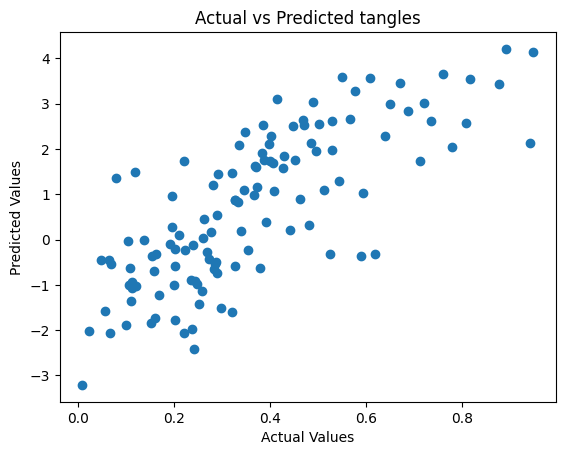

In [18]:
# Scatter plot of actual vs predicted values
plt.scatter(y_true, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted tangles")

plt.show()

# Get prediction for amyloid (BiLSTM)

In [19]:
# Load your pretrained weights into the modified model
model = Model_AllTimeSteps_BiLSTMasTrue(
    input_dim=57, 
    hidden_dim=32, 
    output_dim=4, 
    num_layers=3, 
    dropout=0.2
)
model.load_state_dict(torch.load(MODEL_INPUT_DIR / "final_model_amyloid_BiLSTM.pth"))
model.eval()
# During inference
results = []
with torch.no_grad():
    for batch_projids, batch_x, batch_y in data_loader:
        # Get predictions from model (shape: batch_size, seq_len, 4)
        predictions = model(batch_x)
        # Get original sequence lengths from the packed input
        _, lengths = torch.nn.utils.rnn.pad_packed_sequence(batch_x, batch_first=True)
        # Convert predictions to numpy
        padded_preds = predictions.numpy()
        
        # Iterate through each sample in the batch
        for i, (projid, seq_len) in enumerate(zip(batch_projids, lengths)):
            # Get corresponding predictions and fu_years
            preds = padded_preds[i, :seq_len]  # Slice to actual sequence length
            fu_years = total_data[total_data['projid'] == projid]['fu_year'].sort_values().values
            
            # Store results
            for t in range(seq_len):
                results.append({
                    'projid': projid,
                    'fu_year': fu_years[t],
                    'gpath_pred': preds[t, 0],
                    'tangles_pred': preds[t, 1],
                    'amyloid_pred': preds[t, 2],
                    'niareagansc_pred': preds[t, 3]
                })

# Convert to DataFrame
results_df = pd.DataFrame(results)

/var/folders/lq/ztc8254x6yd88ts29wxbyy5w0000gn/T/ipykernel_41540/3170205719.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_INPUT_

In [20]:
amyloid_df = results_df[['projid', 'fu_year', 'amyloid_pred']]
print(amyloid_df)

         projid  fu_year  amyloid_pred
0      20987152        0     -6.350309
1      20987152        1     -9.069371
2      20987152        2    -10.111076
3      20987152        3    -10.471031
4      20987152        4    -10.583424
...         ...      ...           ...
10388  90821208        0      0.404551
10389  94370928        0     -2.092619
10390  94549523        0     -0.529939
10391  95330358        0     -0.323970
10392  99718754        0     -0.403143

[10393 rows x 3 columns]


- validate the prediction R^2 for the last visit

In [21]:
# Get last visit predictions for each subject
last_visit_preds = results_df.sort_values(['projid', 'fu_year']).groupby('projid').tail(1)

# Merge with original data
merged_df = pd.merge(
    last_visit_preds,
    total_data[['projid', 'fu_year', 'gpath', 'tangles', 'amyloid', 'niareagansc']],
    on=['projid', 'fu_year']
)

# Calculate R^2
target = 'tangles'
metrics = []

y_true = merged_df[f'{target}']
y_pred = merged_df[f'{target}_pred']

r, _ = pearsonr(y_true, y_pred)
r2_pearson = r**2

print(f"Pearson R²: {r2_pearson:.3f}")
print(f"Sample Size: {len(y_true)}")

Pearson R²: nan
Sample Size: 1128


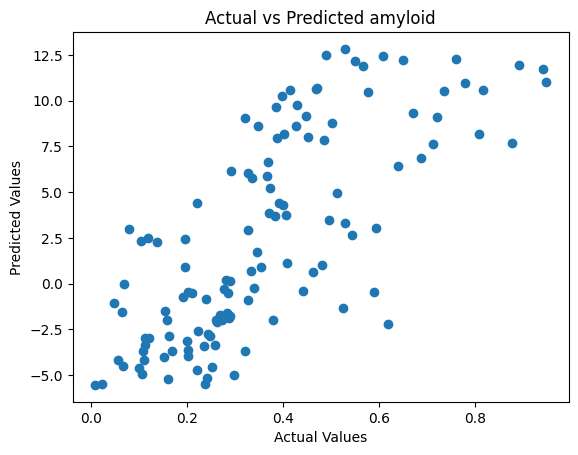

In [22]:
# Scatter plot of actual vs predicted values
plt.scatter(y_true, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted amyloid")

plt.show()

# Get prediction for nia (BiLSTM)

In [23]:
# Load your pretrained weights into the modified model
model = Model_AllTimeSteps_BiLSTMasTrue(
    input_dim=57, 
    hidden_dim=32, 
    output_dim=4, 
    num_layers=4, 
    dropout=0
)

model.load_state_dict(torch.load(MODEL_INPUT_DIR / "final_model_nia_BiLSTM.pth"))
model.eval()
# During inference
results = []
with torch.no_grad():
    for batch_projids, batch_x, batch_y in data_loader:
        # Get predictions from model (shape: batch_size, seq_len, 4)
        predictions = model(batch_x)
        # Get original sequence lengths from the packed input
        _, lengths = torch.nn.utils.rnn.pad_packed_sequence(batch_x, batch_first=True)
        # Convert predictions to numpy
        padded_preds = predictions.numpy()
        
        # Iterate through each sample in the batch
        for i, (projid, seq_len) in enumerate(zip(batch_projids, lengths)):
            # Get corresponding predictions and fu_years
            preds = padded_preds[i, :seq_len]  # Slice to actual sequence length
            fu_years = total_data[total_data['projid'] == projid]['fu_year'].sort_values().values
            
            # Store results
            for t in range(seq_len):
                results.append({
                    'projid': projid,
                    'fu_year': fu_years[t],
                    'gpath_pred': preds[t, 0],
                    'tangles_pred': preds[t, 1],
                    'amyloid_pred': preds[t, 2],
                    'niareagansc_pred': preds[t, 3]
                })

# Convert to DataFrame
results_df = pd.DataFrame(results)

/var/folders/lq/ztc8254x6yd88ts29wxbyy5w0000gn/T/ipykernel_41540/3265135382.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_INPUT

In [24]:
nia_df = results_df[['projid', 'fu_year', 'niareagansc_pred']]
print(nia_df)

         projid  fu_year  niareagansc_pred
0      20987152        0         -4.083946
1      20987152        1         -6.006608
2      20987152        2         -6.212005
3      20987152        3         -5.980244
4      20987152        4         -5.741431
...         ...      ...               ...
10388  90821208        0         -0.567649
10389  94370928        0         -1.579338
10390  94549523        0         -0.883292
10391  95330358        0         -0.598586
10392  99718754        0         -1.367457

[10393 rows x 3 columns]


In [25]:
# Get last visit predictions for each subject
last_visit_preds = results_df.sort_values(['projid', 'fu_year']).groupby('projid').tail(1)

# Merge with original data
merged_df = pd.merge(
    last_visit_preds,
    total_data[['projid', 'fu_year', 'gpath', 'tangles', 'amyloid', 'niareagansc']],
    on=['projid', 'fu_year']
)

# Calculate R^2
target = 'niareagansc'
metrics = []

y_true = merged_df[f'{target}']
y_pred = merged_df[f'{target}_pred']

r, _ = pearsonr(y_true, y_pred)
r2_pearson = r**2

print(f"Pearson R²: {r2_pearson:.3f}")
print(f"Sample Size: {len(y_true)}")

Pearson R²: nan
Sample Size: 1128


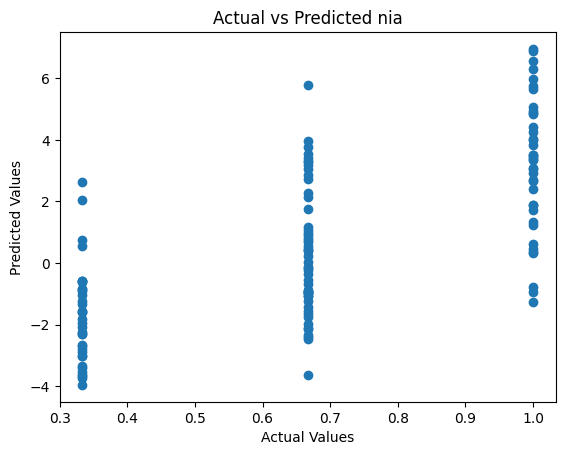

In [26]:
# Scatter plot of actual vs predicted values
plt.scatter(y_true, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted nia")

plt.show()

# Save predictions

In [27]:
merged_df = pd.merge(gpath_df, tangles_df, on=['projid', 'fu_year'])
merged_df = pd.merge(merged_df, amyloid_df, on=['projid', 'fu_year'])
merged_results_df = pd.merge(merged_df, nia_df, on=['projid', 'fu_year'])

desired_columns = ['projid', 'fu_year', 'gpath_pred', 'tangles_pred', 'amyloid_pred', 'niareagansc_pred']
merged_results_df = merged_results_df[desired_columns]
print(merged_results_df)


         projid  fu_year  gpath_pred  tangles_pred  amyloid_pred  \
0      20987152        0    0.190243     -0.846555     -6.350309   
1      20987152        1   -0.690135     -1.759056     -9.069371   
2      20987152        2   -0.472715     -1.620265    -10.111076   
3      20987152        3   -0.247731     -1.416600    -10.471031   
4      20987152        4   -0.173131     -1.271611    -10.583424   
...         ...      ...         ...           ...           ...   
10388  90821208        0    0.221417     -0.448975      0.404551   
10389  94370928        0    0.043043     -1.018029     -2.092619   
10390  94549523        0    0.199554     -0.500241     -0.529939   
10391  95330358        0    0.204048     -0.462091     -0.323970   
10392  99718754        0    0.099223     -0.680218     -0.403143   

       niareagansc_pred  
0             -4.083946  
1             -6.006608  
2             -6.212005  
3             -5.980244  
4             -5.741431  
...                 ...  
1

In [28]:
save_path = OUTPUT_DIR / "predicted_gpath_tangles_amyloid_nia_ModifiedNIAValue_only_for_livings1106.csv"
merged_results_df.to_csv(save_path, index=False)